

![image-20201226152702981](images/image-20201226152702981.png)


数据集State-of-the-Art详见

- [mnist](https://paperswithcode.com/sota/image-classification-on-mnist)
- [fashion-mnist](https://paperswithcode.com/sota/image-classification-on-fashion-mnist)
- [cifar-10](https://paperswithcode.com/sota/image-classification-on-cifar-10)


## Configuration


In [1]:
%%bash
 
# pip install -U ipyparams 
#pip install -U tensorflow_hub 
#pip install -U ipython
# pip install -U pymysql pyodbc
# pip install -U fasttext
# pip install -U seaborn

In [2]:
import csv
import ipyparams
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import re
import shutil
import string  
import sys
import tensorflow as tf
import tensorflow_hub as hub

from collections import Counter
from joblib import Parallel, delayed
from scipy import stats
from sklearn import feature_extraction, feature_selection
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model, models, layers, regularizers, preprocessing, datasets, metrics, losses, optimizers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorboard.plugins.hparams import api as hp 
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

base_path = os.path.abspath('/tf/eipi10/jian-xu3/qbz95')
sys.path.append(base_path)

import qbz95
from qbz95 import tf as qtf

pd.set_option('display.max_colwidth', None)
# set gpu memory
qtf.utils.set_gpu_memory_growth()

# auto load the changes of referenced codes
%load_ext autoreload
%autoreload 2

# ebablbe auto-completion
%config Completer.use_jedi = False

<IPython.core.display.Javascript object>

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.10) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [3]:
%reload_ext autoreload

### Initial Parameters

In [4]:
def lr_schedule(epoch, lr):
    """config the strategy of reducing learning rate"""
    lr_times = [(0, 1), (60, 1e-1), (90, 1e-2), (105, 1e-3), (120, 0.5e-3)]
    
    base_lr = 1e-3
    new_lr = base_lr
    for border_epoch, times in lr_times:
        if epoch>=border_epoch: 
            new_lr = base_lr*times
    if abs(lr - new_lr)>1e-7:
        if new_lr > lr > 0.1*new_lr - 1e-7:
            print('Epoch %05d: Still keep learning rate %s instead of %s' % 
                  (epoch + 1, round(lr, 7), round(new_lr, 7))) 
            return lr   
        print('Epoch %05d: LearningRateScheduler reducing learning rate to %s from %s.' % 
              (epoch + 1, round(new_lr, 7), round(lr, 7)))
    return new_lr

data_generator = preprocessing.image.ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False) 

notebook_name_params = qbz95.utils.get_notebook_name().split('.')[0].split('_')

output_path = os.path.abspath('./output')
data_name = notebook_name_params[0]
data_path = os.path.join(output_path, data_name)
program_path = os.path.join(data_path, qbz95.utils.get_notebook_name().split('.')[0])
word_vectors_path = '/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/models/word_vectors'
classes = ['cats', 'dogs']

train_image_count =  int(notebook_name_params[3])
use_data_augmentation = True if len(notebook_name_params)>=5 and notebook_name_params[4]=='aug' else False

params = {
    'data_name': data_name,
    'data_path': data_path,
    'train_image_count':train_image_count,
    'use_data_augmentation': use_data_augmentation,
    'augmentation_generator': data_generator,       
    'program_name': qbz95.utils.get_notebook_name(),
    'program_path': program_path,
    'classes': classes,
    'word_vectors_path': word_vectors_path,
    'sample_perecent': 1,    
    'validation_percent': 0.0,  
    'use_stop_words': True,    
    'batch_size': 32,    
    'epochs': 3,    
    'steps_per_epoch': int(train_image_count*len(classes)/32),
    'learning_rate':0.001,
    'clip_value':None,
    'dropout':0.1,
    'metrics':['accuracy'], 
    'loss': losses.SparseCategoricalCrossentropy(from_logits=True),
    'restore_best_checkpoint':True,
    'use_savedmodel':True,
    'use_bias_initializer':False,
    'use_class_weight':False,
    'class_weight': [1.0, 1.0],
    'callbacks': {
        'ModelCheckpoint': {
            'enabled': True,
            'monitor': 'val_accuracy',               
        },
        'EarlyStopping': {
            'enabled': True,
            'patience': 40,   
            'monitor': 'val_accuracy',            
        },
        'ReduceLROnPlateau': {
            'enabled': False,
            'monitor': 'val_loss',
            'patience': 15,
            'factor': np.sqrt(0.1),            
        },
        'LearningRateScheduler': {
            'enabled': False,
            'schedule': lr_schedule,            
        }             
    },
    'fine_tune_callbacks': {
        'ModelCheckpoint': {
            'enabled': True,
            'monitor': 'val_accuracy',               
        },
        'EarlyStopping': {
            'enabled': True,
            'patience': 40,   
            'monitor': 'val_accuracy',            
        },
        'ReduceLROnPlateau': {
            'enabled': True,
            'monitor': 'val_loss',
            'patience': 15,
            'factor': np.sqrt(0.1),            
        }            
    },    
    'model_params':{
        'mlp':{'dropout':0.3, 'layer_count':1, 'units':128, 'epochs':20},
        'lenet':{'dropout':0.4, 'epochs':20},
        'custom':{'dropout':0.4, 'epochs':20},
        'vgg':{'dropout':0.4, 'epochs':20, 'learning_rate':0.001},
        'resnet':{'dropout':0.4, 'epochs':20},
        'pretrained':{'dropout':0.3, 'epochs':20, 'learning_rate':0.0001}         
    },
    'embedding_paths':{
    },
    'keras_layper_paths':{
    },
    'model_resutls':{
        'show_top_n':20,
        'show_exclude_columns':qtf.classification.ModelResults.exclude_columns1
    }
}

params = qtf.classification.Params(params)
model_results=qtf.classification.ProgramModelResults(params.program_path)
# model_results.clear()

In [5]:
params.use_data_augmentation

False

## Get Data

### Download Data 

In [6]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

In [7]:
!ls -l $train_dir
!ls -l $train_dir/cats | wc -l
!ls -l $train_dir/dogs | wc -l
!ls -l $train_dir/cats | head -5

!ls -l $validation_dir/cats | wc -l 
!ls -l $validation_dir/dogs | wc -l

total 84
drwxr-xr-x. 2 root root 24576 Aug 17 05:13 cats
drwxr-xr-x. 2 root root 24576 Aug 17 05:13 dogs
1001
1001
total 22644
-rw-r--r--. 1 root root 12414 Aug 17 07:48 cat.0.jpg
-rw-r--r--. 1 root root 16880 Aug 17 07:48 cat.1.jpg
-rw-r--r--. 1 root root 34315 Aug 17 07:48 cat.10.jpg
-rw-r--r--. 1 root root 28377 Aug 17 07:48 cat.100.jpg
ls: write error: Broken pipe
501
501


In [8]:
def image_to_array(img_file):
    img = load_img(img_file) 
    img = img.resize((160, 160))
    x = img_to_array(img) 
    return x

def images_to_array(image_folder):
    files = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if os.path.isfile(os.path.join(image_folder, f))]
    x = np.array([image_to_array(file) for file in files])
    return x 

def load_image_folder(image_folder, classes):
    x = None
    y = None
    for i, class_ in enumerate(classes):
        folder = os.path.join(image_folder, class_) 
        x_ = images_to_array(folder)
        y_ = [i]*len(x_)
        if x is None:
            x = x_
            y = y_
        else:
            x = np.concatenate([x, x_])
            y = np.concatenate([y, y_])
        
    return x, y

train_images, train_labels = load_image_folder(train_dir, params.classes)
print(train_images.shape, train_labels.shape)

test_images, test_labels = load_image_folder(validation_dir, params.classes)
print(test_images.shape, test_labels.shape)

(2000, 160, 160, 3) (2000,)
(1000, 160, 160, 3) (1000,)


In [9]:
if params.train_image_count*len(classes)<len(train_images):
    _, train_images, _, train_labels = train_test_split(train_images, train_labels, test_size=params.train_image_count*len(classes), random_state=42)

    print(train_images.shape, train_labels.shape)
    print(test_images.shape, test_labels.shape)

(200, 160, 160, 3) (200,)
(1000, 160, 160, 3) (1000,)


In [10]:
Counter(train_labels)

Counter({1: 101, 0: 99})



### Data Explore 

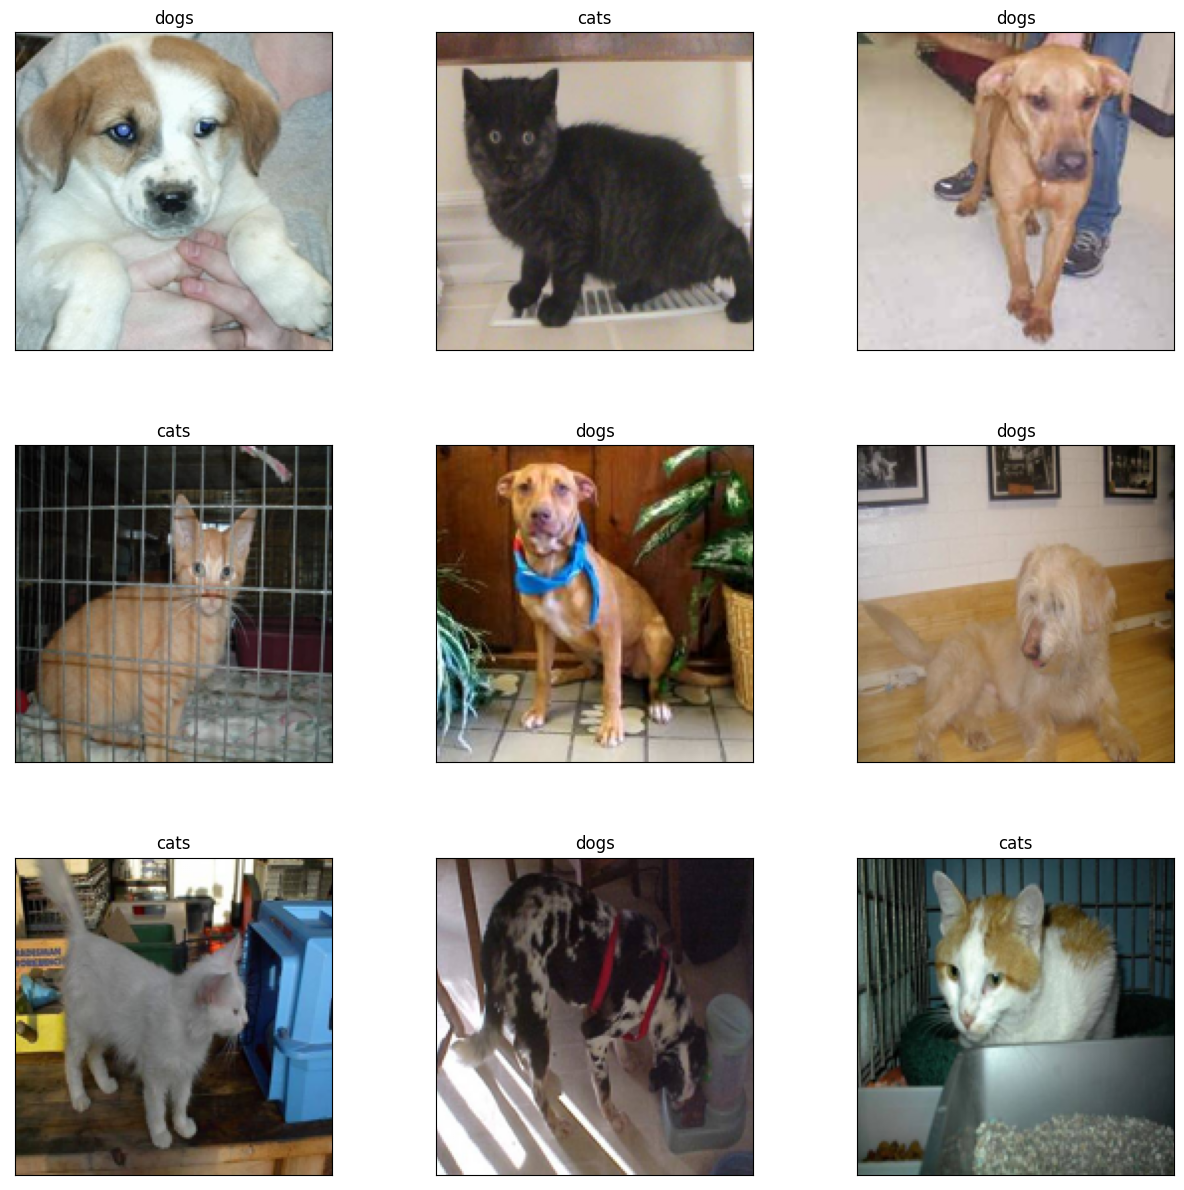

In [11]:
qtf.utils.show_images(train_images, train_labels, classes=params.classes, x_num=3, y_num=3, figsize=(12, 12))

### Class Distribution

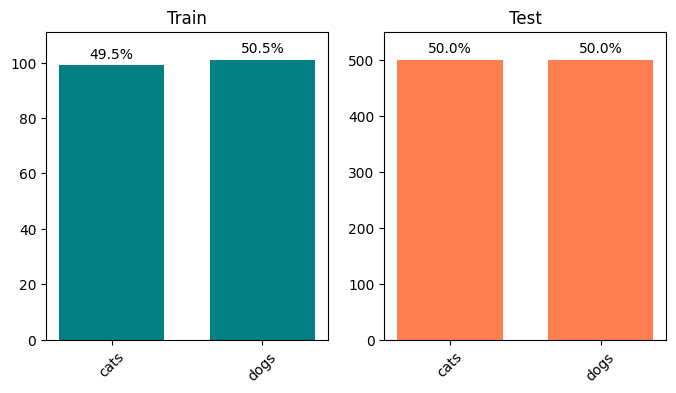

In [12]:
qtf.utils.plot_distribution(train_labels, test_labels, params.classes)



## Prepare Data


### Raw Data


In [13]:
raw_datasets = qtf.classification.Datasets(train_images, train_labels, test_images, test_labels, batch_size=params.batch_size)

In [14]:
sample_images, sample_labels = iter(raw_datasets.train_dataset).next()

In [15]:
raw_datasets.train_dataset.element_spec

(TensorSpec(shape=(32, 160, 160, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(32,), dtype=tf.int64, name=None))

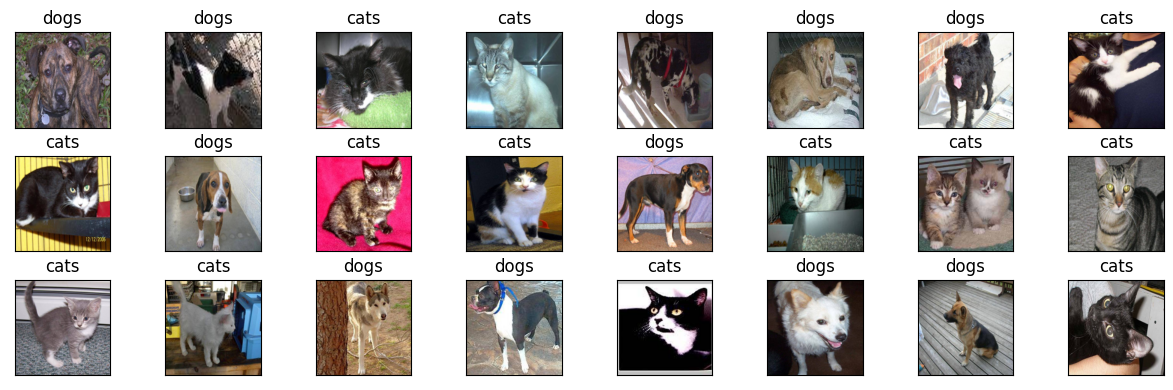

In [16]:
qtf.utils.show_images(sample_images.numpy(), sample_labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4))

### Data Augmentation

In [17]:
data_generator.fit(train_images)
generator = {'train':qtf.classification.AugmentGenerator('augment', data_generator), 
             'val_test':qtf.classification.DatasetGenerator('val_test')}
augment_datasets = qtf.classification.Datasets(train_images, train_labels, test_images, test_labels, 
                                               generator=generator, batch_size=params.batch_size, 
                                               use_shuffle=False)

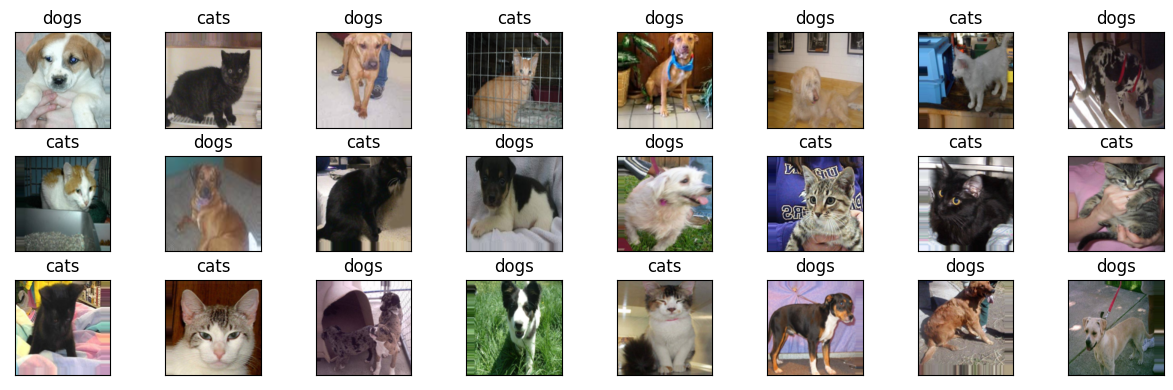

In [18]:
images, labels = iter(augment_datasets.train_dataset).next() 
qtf.utils.show_images(images, labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4)) 

see orgin images

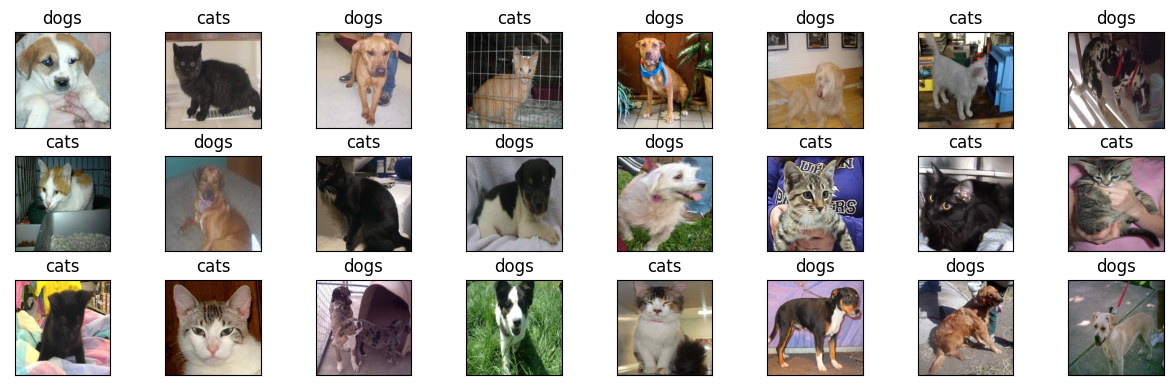

In [19]:
qtf.utils.show_images(train_images, train_labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4)) 

create data augment dataset

In [20]:
augment_datasets = qtf.classification.Datasets(train_images, train_labels, test_images, test_labels, 
                                               generator=generator, batch_size=params.batch_size, 
                                               use_shuffle=True)

In [21]:
print(f'use_data_augmentation = {params.use_data_augmentation}')
if params.use_data_augmentation:
    datasets = augment_datasets
else:
    datasets = raw_datasets

use_data_augmentation = False


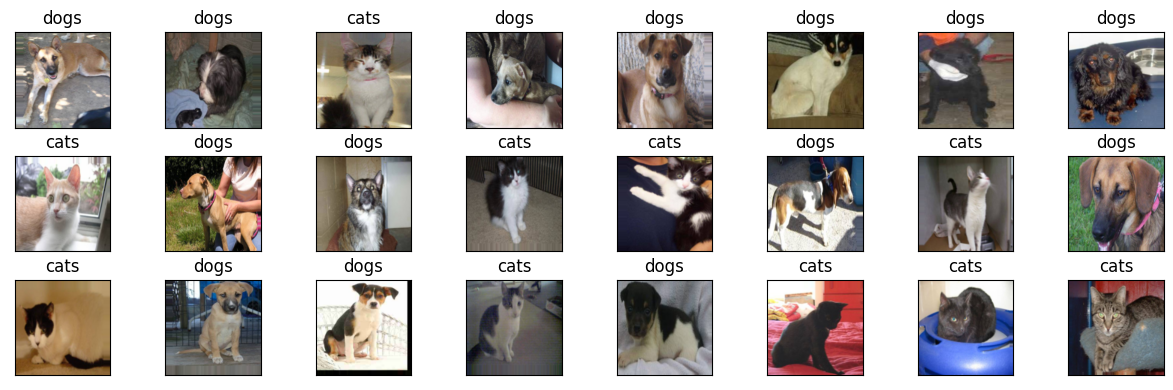

In [22]:
images, labels = iter(augment_datasets.train_dataset).next() 
qtf.utils.show_images(images, labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4)) 



##  Models



In [23]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

### MLP

2022-08-17 07:48:31,021: INFO: model_params.mlp1.dropout=0.3
2022-08-17 07:48:31,022: INFO: model_params.mlp1.layer_count=1
2022-08-17 07:48:31,023: INFO: model_params.mlp1.units=128
2022-08-17 07:48:31,064: INFO: learning_rate=0.001
2022-08-17 07:48:31,065: INFO: model_params.mlp1.clip_value=None
2022-08-17 07:48:31,253: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_100/mlp1


Model: "mlp1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 160, 160, 3)       0         
                                                                 
 flatten (Flatten)           (None, 76800)             0         
                                                                 
 dense (Dense)               (None, 128)               9830528   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
Total params: 9,830,786
Trainable params: 9,830,786
Non-traina

2022-08-17 07:48:31,267: INFO: model_params.mlp1.epochs=20
2022-08-17 07:48:31,268: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_100/mlp1, monitor=val_accuracy)
2022-08-17 07:48:31,269: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2022-08-17 07:48:31,269: INFO: steps_per_epoch=6
2022-08-17 07:48:31,270: INFO: start training
2022-08-17 07:48:31,270: INFO: use_class_weight=False


Epoch 1/20
1/6 [====>.........................] - ETA: 3s - loss: 0.7703 - accuracy: 0.5312INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_100/mlp1/assets


2022-08-17 07:48:33,605: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_100/mlp1/assets


6/6 [==============================] - 2s 328ms/step - loss: 11.5703 - accuracy: 0.5156 - val_loss: 10.8050 - val_accuracy: 0.5460
Epoch 2/20
1/6 [====>.........................] - ETA: 0s - loss: 4.3857 - accuracy: 0.7188INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_100/mlp1/assets


2022-08-17 07:48:34,682: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_100/mlp1/assets


6/6 [==============================] - 1s 213ms/step - loss: 7.5269 - accuracy: 0.7031 - val_loss: 18.5224 - val_accuracy: 0.5640
Epoch 3/20
6/6 [==============================] - 0s 38ms/step - loss: 6.0481 - accuracy: 0.7917 - val_loss: 15.9975 - val_accuracy: 0.5400
Epoch 4/20
6/6 [==============================] - 0s 38ms/step - loss: 1.9203 - accuracy: 0.8385 - val_loss: 12.8702 - val_accuracy: 0.5600
Epoch 5/20
6/6 [==============================] - 0s 38ms/step - loss: 2.6815 - accuracy: 0.8438 - val_loss: 13.0045 - val_accuracy: 0.5510
Epoch 6/20
6/6 [==============================] - 0s 37ms/step - loss: 1.6245 - accuracy: 0.8854 - val_loss: 13.1226 - val_accuracy: 0.5440
Epoch 7/20
6/6 [==============================] - 0s 37ms/step - loss: 0.2562 - accuracy: 0.9583 - val_loss: 12.6353 - val_accuracy: 0.5360
Epoch 8/20
6/6 [==============================] - 0s 37ms/step - loss: 0.9148 - accuracy: 0.9375 - val_loss: 13.6775 - val_accuracy: 0.5390
Epoch 9/20
6/6 [==============

2022-08-17 07:48:38,304: INFO: finish training [elapsed time: 7.03 seconds]


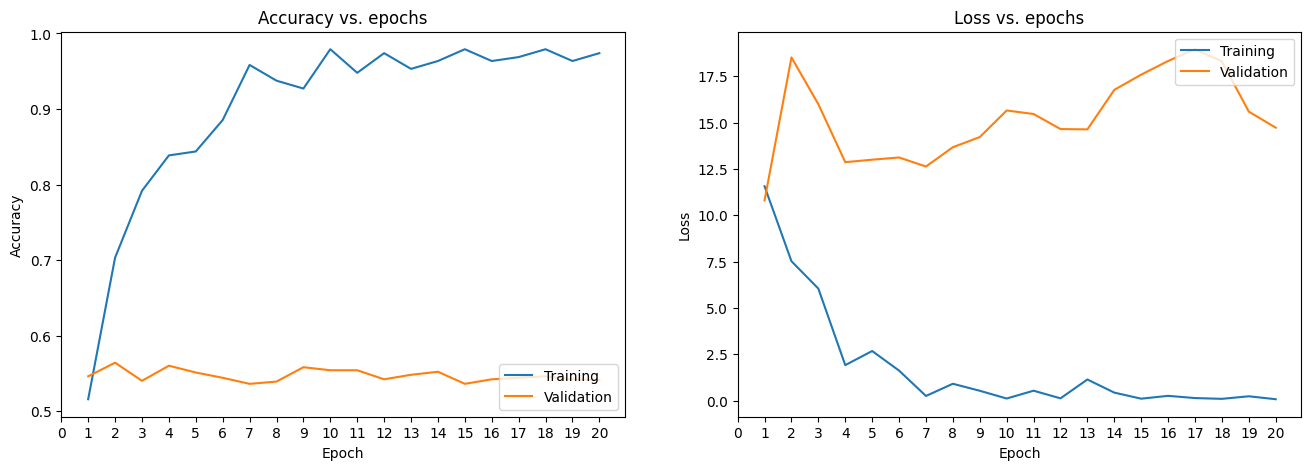

2022-08-17 07:48:38,759: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_100/mlp1


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_100/mlp1
----------------------------------------evaluate----------------------------------------
32/32 [==============================] - 0s 5ms/step


2022-08-17 07:48:41,867: INFO: test loss:18.5224
2022-08-17 07:48:41,867: INFO: test accuracy:0.5640
2022-08-17 07:48:41,868: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_100/results.json
2022-08-17 07:48:41,870: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_100/results.json
2022-08-17 07:48:41,871: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_100/default.generator
2022-08-17 07:48:41,872: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_100/default.generator


----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------
32/32 [==============================] - 0s 5ms/step


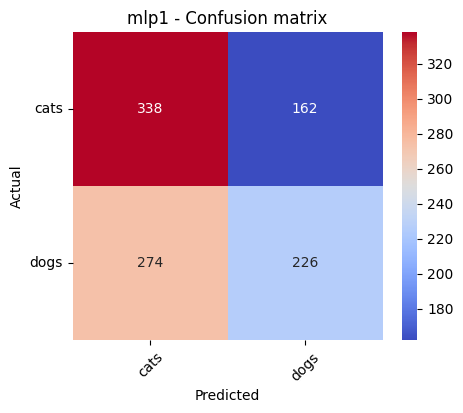

----------------------------------------models----------------------------------------


model_name                 program_name  weight_number  train_time  \
1       mlp1  catsdogs_0808_cnt_100.ipynb        9830786         7.0   

        create_time  train_loss  test_loss  train_accuracy  test_accuracy  \
1  2022-08-17 07:48      6.9909    18.5224            0.74          0.564   

   train_auc  test_auc  
1     0.8192    0.5766

In [24]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.mlp1(helper, name='mlp1', preprocess_fun=rescale)
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=False) 




### LeNet

![image-20201019113632136](images/image-20201019113632136.png)


2022-08-17 07:48:43,129: INFO: model_params.lenet1.dropout=0.4
2022-08-17 07:48:43,219: INFO: learning_rate=0.001
2022-08-17 07:48:43,220: INFO: model_params.lenet1.clip_value=None
2022-08-17 07:48:43,226: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_100/lenet1


Model: "lenet1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 160, 160, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 160, 160, 6)       456       
                                                                 
 batch_normalization (BatchN  (None, 160, 160, 6)      24        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 80, 80, 6)        0         
 )                                                               
                                                                 
 dropout_1 (Dropout)         (None, 80, 80, 6)         0    

2022-08-17 07:48:43,255: INFO: model_params.lenet1.epochs=20
2022-08-17 07:48:43,256: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_100/lenet1, monitor=val_accuracy)
2022-08-17 07:48:43,257: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2022-08-17 07:48:43,257: INFO: steps_per_epoch=6
2022-08-17 07:48:43,258: INFO: start training
2022-08-17 07:48:43,259: INFO: use_class_weight=False


Epoch 1/20
5/6 [========================>.....] - ETA: 0s - loss: 3.2911 - accuracy: 0.5250

2022-08-17 07:48:46,578: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_100/lenet1/assets


2022-08-17 07:48:47,148: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_100/lenet1/assets


6/6 [==============================] - 4s 480ms/step - loss: 3.2063 - accuracy: 0.5469 - val_loss: 0.7027 - val_accuracy: 0.5650
Epoch 2/20
6/6 [==============================] - 0s 56ms/step - loss: 4.3181 - accuracy: 0.5208 - val_loss: 0.7379 - val_accuracy: 0.5220
Epoch 3/20
6/6 [==============================] - 0s 55ms/step - loss: 2.5943 - accuracy: 0.5833 - val_loss: 0.7568 - val_accuracy: 0.5510
Epoch 4/20
6/6 [==============================] - 0s 55ms/step - loss: 2.4078 - accuracy: 0.6510 - val_loss: 0.7882 - val_accuracy: 0.5460
Epoch 5/20
6/6 [==============================] - 0s 56ms/step - loss: 1.6661 - accuracy: 0.6406 - val_loss: 0.8527 - val_accuracy: 0.5300
Epoch 6/20
6/6 [==============================] - 0s 55ms/step - loss: 1.2174 - accuracy: 0.6510 - val_loss: 0.9544 - val_accuracy: 0.5310
Epoch 7/20
6/6 [==============================] - 0s 55ms/step - loss: 0.7658 - accuracy: 0.7135 - val_loss: 1.1385 - val_accuracy: 0.5330
Epoch 8/20
6/6 [=====================

2022-08-17 07:48:52,839: INFO: finish training [elapsed time: 9.58 seconds]


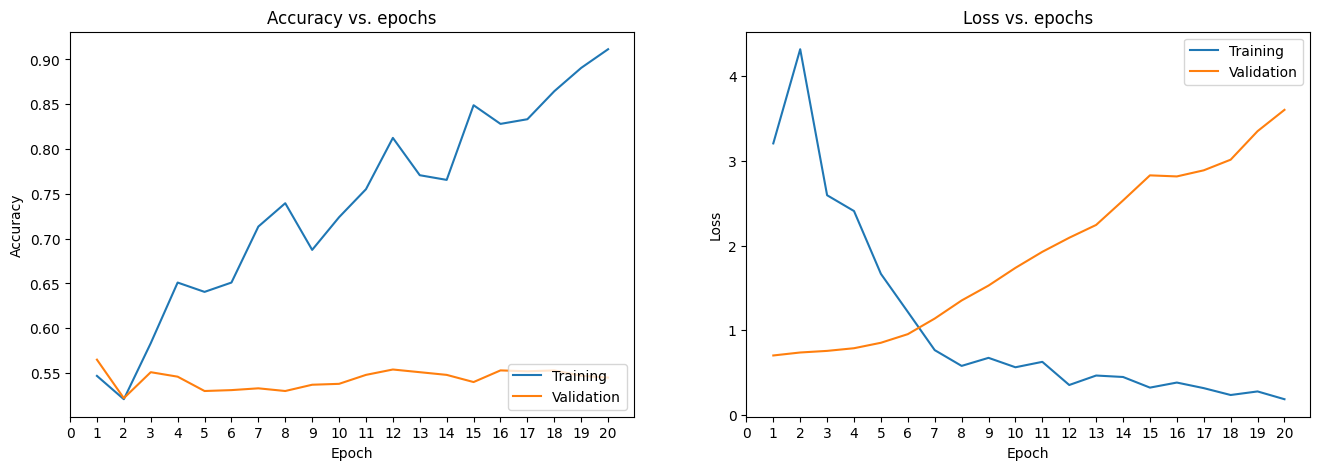

2022-08-17 07:48:53,247: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_100/lenet1


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_100/lenet1
----------------------------------------evaluate----------------------------------------
32/32 [==============================] - 0s 6ms/step


2022-08-17 07:48:56,867: INFO: test loss:0.7027
2022-08-17 07:48:56,867: INFO: test accuracy:0.5650
2022-08-17 07:48:56,869: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_100/results.json
2022-08-17 07:48:56,870: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_100/results.json
2022-08-17 07:48:56,871: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_100/default.generator
2022-08-17 07:48:56,872: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_100/default.generator
2022-08-17 07:48:56,872: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_100/ml

----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2022-08-17 07:48:57,246: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_100/default.generator


32/32 [==============================] - 0s 5ms/step


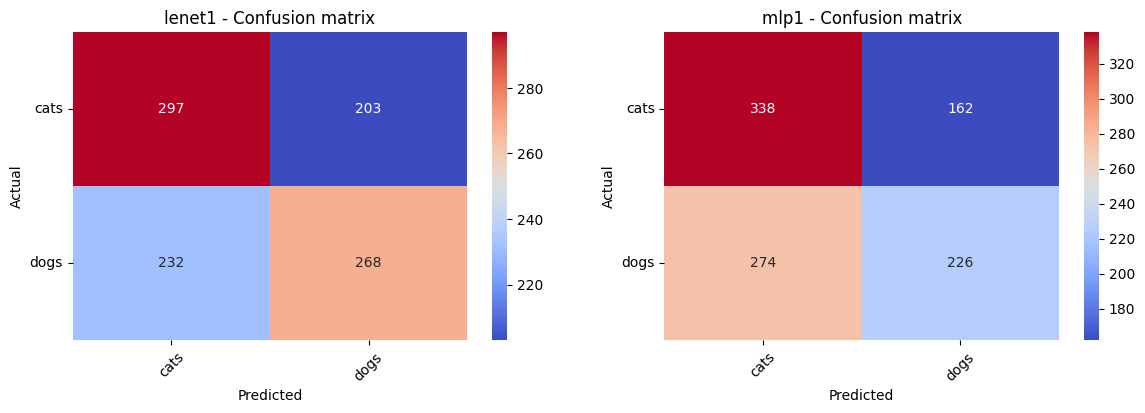

----------------------------------------models----------------------------------------


model_name                 program_name  weight_number  train_time  \
1     lenet1  catsdogs_0808_cnt_100.ipynb        2785850         9.6   
2       mlp1  catsdogs_0808_cnt_100.ipynb        9830786         7.0   

        create_time  train_loss  test_loss  train_accuracy  test_accuracy  \
1  2022-08-17 07:48      0.6312     0.7027           0.665          0.565   
2  2022-08-17 07:48      6.9909    18.5224           0.740          0.564   

   train_auc  test_auc  
1     0.6944    0.5830  
2     0.8192    0.5766

In [25]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.lenet1(helper, name='lenet1', preprocess_fun=rescale)
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=False) 

### Custom 1


2022-08-17 07:48:59,748: INFO: model_params.custom1.dropout=0.4
2022-08-17 07:48:59,850: INFO: learning_rate=0.001
2022-08-17 07:48:59,850: INFO: model_params.custom1.clip_value=None
2022-08-17 07:48:59,856: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_100/custom1


Model: "custom1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 160, 160, 3)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 160, 160, 32)      896       
                                                                 
 batch_normalization_2 (Batc  (None, 160, 160, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 80, 80, 32)       0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 80, 80, 32)        0   

2022-08-17 07:48:59,890: INFO: model_params.custom1.epochs=20
2022-08-17 07:48:59,890: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_100/custom1, monitor=val_accuracy)
2022-08-17 07:48:59,891: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2022-08-17 07:48:59,892: INFO: steps_per_epoch=6
2022-08-17 07:48:59,892: INFO: start training
2022-08-17 07:48:59,893: INFO: use_class_weight=False


Epoch 1/20
5/6 [========================>.....] - ETA: 0s - loss: 7.8548 - accuracy: 0.4812 

2022-08-17 07:49:03,246: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_100/custom1/assets


2022-08-17 07:49:03,896: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_100/custom1/assets


6/6 [==============================] - 4s 568ms/step - loss: 7.3215 - accuracy: 0.4844 - val_loss: 0.7138 - val_accuracy: 0.5140
Epoch 2/20
5/6 [========================>.....] - ETA: 0s - loss: 1.7487 - accuracy: 0.5437

2022-08-17 07:49:05,789: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_100/custom1/assets


2022-08-17 07:49:06,454: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_100/custom1/assets


6/6 [==============================] - 3s 504ms/step - loss: 1.6921 - accuracy: 0.5625 - val_loss: 2.0097 - val_accuracy: 0.5310
Epoch 3/20
6/6 [==============================] - 1s 95ms/step - loss: 0.9531 - accuracy: 0.5938 - val_loss: 5.1794 - val_accuracy: 0.4990
Epoch 4/20
6/6 [==============================] - 1s 96ms/step - loss: 0.6116 - accuracy: 0.6823 - val_loss: 7.4229 - val_accuracy: 0.4980
Epoch 5/20
6/6 [==============================] - 1s 97ms/step - loss: 0.5661 - accuracy: 0.7396 - val_loss: 8.5093 - val_accuracy: 0.5010
Epoch 6/20
6/6 [==============================] - 1s 96ms/step - loss: 0.5781 - accuracy: 0.7031 - val_loss: 8.7368 - val_accuracy: 0.5000
Epoch 7/20
6/6 [==============================] - 1s 95ms/step - loss: 0.5085 - accuracy: 0.7812 - val_loss: 8.3351 - val_accuracy: 0.5000
Epoch 8/20
6/6 [==============================] - 1s 96ms/step - loss: 0.4532 - accuracy: 0.7969 - val_loss: 7.5191 - val_accuracy: 0.5000
Epoch 9/20
6/6 [=====================

2022-08-17 07:49:15,810: INFO: finish training [elapsed time: 15.92 seconds]


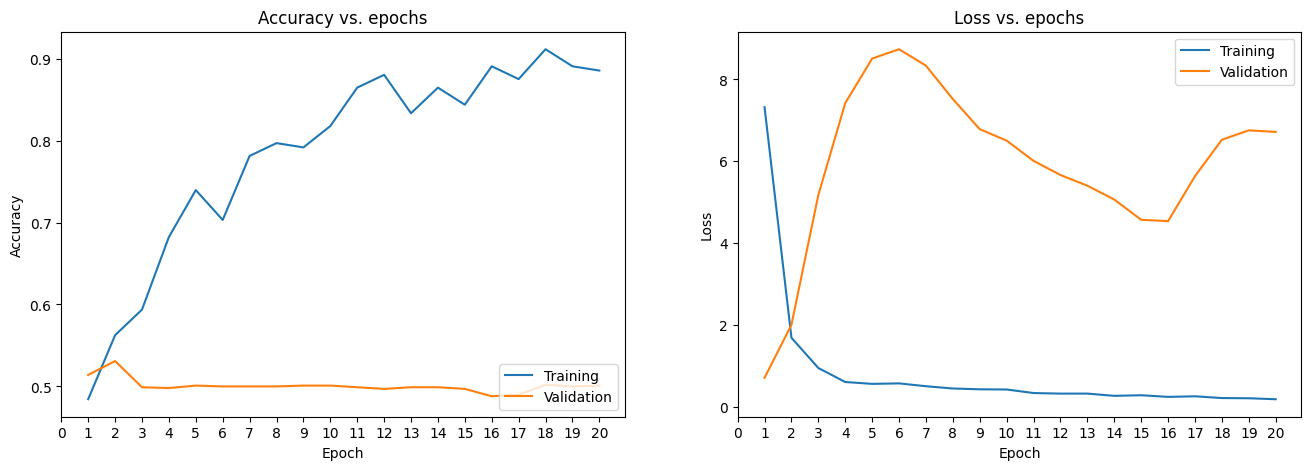

2022-08-17 07:49:16,212: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_100/custom1


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_100/custom1
----------------------------------------evaluate----------------------------------------
32/32 [==============================] - 1s 9ms/step


2022-08-17 07:49:20,323: INFO: test loss:2.0097
2022-08-17 07:49:20,324: INFO: test accuracy:0.5310
2022-08-17 07:49:20,325: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_100/results.json
2022-08-17 07:49:20,327: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_100/results.json
2022-08-17 07:49:20,328: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_100/default.generator
2022-08-17 07:49:20,329: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_100/default.generator
2022-08-17 07:49:20,329: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_100/le

----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2022-08-17 07:49:21,150: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_100/default.generator


32/32 [==============================] - 1s 6ms/step


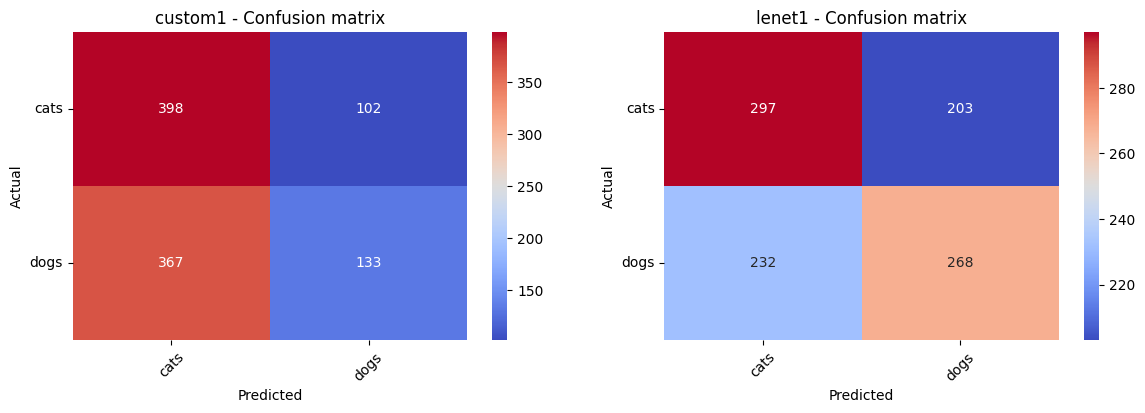

----------------------------------------models----------------------------------------


model_name                 program_name  weight_number  train_time  \
1     lenet1  catsdogs_0808_cnt_100.ipynb        2785850         9.6   
2       mlp1  catsdogs_0808_cnt_100.ipynb        9830786         7.0   
3    custom1  catsdogs_0808_cnt_100.ipynb        1383938        15.9   

        create_time  train_loss  test_loss  train_accuracy  test_accuracy  \
1  2022-08-17 07:48      0.6312     0.7027           0.665          0.565   
2  2022-08-17 07:48      6.9909    18.5224           0.740          0.564   
3  2022-08-17 07:49      1.8811     2.0097           0.600          0.531   

   train_auc  test_auc  
1     0.6944    0.5830  
2     0.8192    0.5766  
3     0.6058    0.5379

In [26]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.custom1(helper, name='custom1', preprocess_fun=rescale)
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=False) 

### VGG

In [27]:
rescale1 = tf.keras.layers.Rescaling(1./255.0)
for data, label in datasets.train_dataset.take(1):
    print(data[0][0][0:5]) 
    print(rescale(data)[0][0][0:5])  

tf.Tensor(
[[133. 118. 212.]
 [129. 116. 208.]
 [104.  95. 187.]
 [ 73.  70. 159.]
 [ 58.  59. 147.]], shape=(5, 3), dtype=float32)
tf.Tensor(
[[ 0.04313731 -0.07450974  0.66274524]
 [ 0.01176476 -0.09019601  0.6313727 ]
 [-0.18431365 -0.25490195  0.4666667 ]
 [-0.42745095 -0.45098037  0.24705887]
 [-0.545098   -0.53725487  0.15294123]], shape=(5, 3), dtype=float32)


In [28]:

helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.vgg1(helper, name='vgg8', dense_layer_count=1, block_count=3, 
                                             preprocess_fun=rescale)
model.summary()


2022-08-17 07:49:23,948: INFO: model_params.vgg8.dropout=0.4
2022-08-17 07:49:24,108: INFO: model_params.vgg8.learning_rate=0.001
2022-08-17 07:49:24,109: INFO: model_params.vgg8.clip_value=None
2022-08-17 07:49:24,115: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_100/vgg8


Model: "vgg8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 160, 160, 3)       0         
                                                                 
 block1_con1 (Conv2D)        (None, 160, 160, 64)      1792      
                                                                 
 block1_bn1 (BatchNormalizat  (None, 160, 160, 64)     256       
 ion)                                                            
                                                                 
 block1_relu1 (ReLU)         (None, 160, 160, 64)      0         
                                                                 
 block1_con2 (Conv2D)        (None, 160, 160, 64)      36928     
                                                              

2022-08-17 07:49:24,245: INFO: model_params.vgg8.epochs=20
2022-08-17 07:49:24,246: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_100/vgg8, monitor=val_accuracy)
2022-08-17 07:49:24,246: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2022-08-17 07:49:24,247: INFO: steps_per_epoch=6
2022-08-17 07:49:24,248: INFO: start training
2022-08-17 07:49:24,248: INFO: use_class_weight=False


Epoch 1/20
6/6 [==============================] - ETA: 0s - loss: 19.5202 - accuracy: 0.5156

2022-08-17 07:49:31,473: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_100/vgg8/assets


2022-08-17 07:49:32,761: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_100/vgg8/assets


6/6 [==============================] - 9s 1s/step - loss: 19.5202 - accuracy: 0.5156 - val_loss: 4.3943 - val_accuracy: 0.4960
Epoch 2/20
6/6 [==============================] - ETA: 0s - loss: 10.1134 - accuracy: 0.5625

2022-08-17 07:49:37,368: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_100/vgg8/assets


2022-08-17 07:49:38,714: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_100/vgg8/assets


6/6 [==============================] - 6s 1s/step - loss: 10.1134 - accuracy: 0.5625 - val_loss: 12.4134 - val_accuracy: 0.5050
Epoch 3/20
6/6 [==============================] - ETA: 0s - loss: 8.5829 - accuracy: 0.5312

2022-08-17 07:49:43,577: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_100/vgg8/assets


2022-08-17 07:49:44,933: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_100/vgg8/assets


6/6 [==============================] - 6s 1s/step - loss: 8.5829 - accuracy: 0.5312 - val_loss: 15.3633 - val_accuracy: 0.5870
Epoch 4/20
6/6 [==============================] - 2s 433ms/step - loss: 4.3988 - accuracy: 0.6615 - val_loss: 9.4706 - val_accuracy: 0.5330
Epoch 5/20
6/6 [==============================] - 2s 433ms/step - loss: 2.4084 - accuracy: 0.5938 - val_loss: 4.6054 - val_accuracy: 0.5510
Epoch 6/20
6/6 [==============================] - 2s 434ms/step - loss: 1.6664 - accuracy: 0.6562 - val_loss: 2.2241 - val_accuracy: 0.5400
Epoch 7/20
6/6 [==============================] - 2s 433ms/step - loss: 1.0796 - accuracy: 0.6667 - val_loss: 1.4449 - val_accuracy: 0.5040
Epoch 8/20
6/6 [==============================] - 2s 434ms/step - loss: 0.9704 - accuracy: 0.6250 - val_loss: 1.0272 - val_accuracy: 0.5010
Epoch 9/20
6/6 [==============================] - 2s 435ms/step - loss: 0.6797 - accuracy: 0.6146 - val_loss: 0.8400 - val_accuracy: 0.4970
Epoch 10/20
6/6 [================

2022-08-17 07:50:24,659: INFO: finish training [elapsed time: 60.41 seconds]


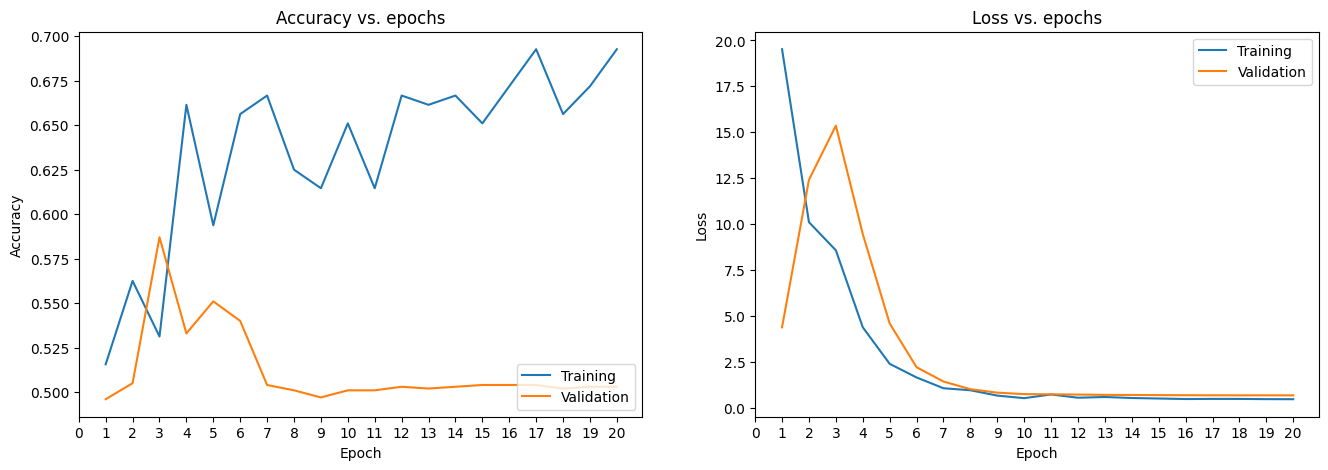

2022-08-17 07:50:25,109: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_100/vgg8


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_100/vgg8
----------------------------------------evaluate----------------------------------------
32/32 [==============================] - 2s 44ms/step


2022-08-17 07:50:32,258: INFO: test loss:15.3633
2022-08-17 07:50:32,259: INFO: test accuracy:0.5870
2022-08-17 07:50:32,261: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_100/results.json
2022-08-17 07:50:32,262: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_100/results.json
2022-08-17 07:50:32,263: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_100/default.generator
2022-08-17 07:50:32,264: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_100/default.generator
2022-08-17 07:50:32,265: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_100/l

----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2022-08-17 07:50:33,402: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_100/default.generator


32/32 [==============================] - 1s 6ms/step


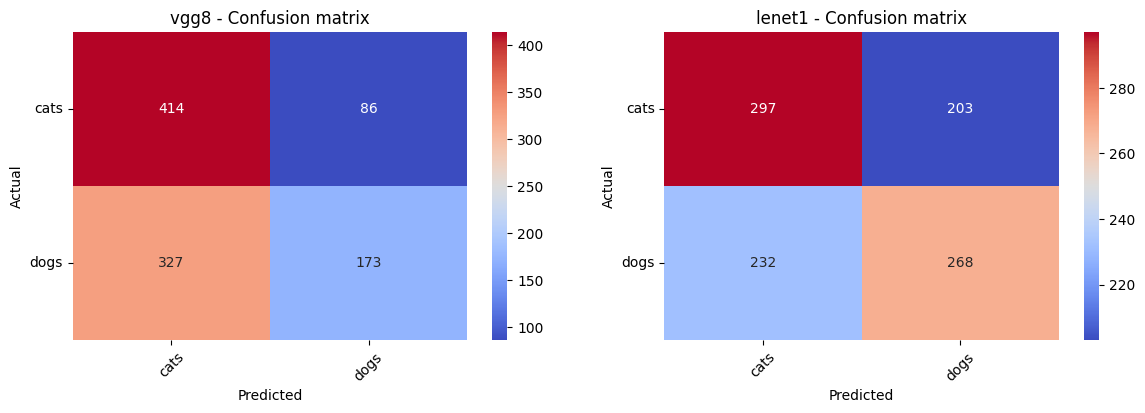

----------------------------------------models----------------------------------------


model_name                 program_name  weight_number  train_time  \
1       vgg8  catsdogs_0808_cnt_100.ipynb       14254786        60.4   
2     lenet1  catsdogs_0808_cnt_100.ipynb        2785850         9.6   
3       mlp1  catsdogs_0808_cnt_100.ipynb        9830786         7.0   
4    custom1  catsdogs_0808_cnt_100.ipynb        1383938        15.9   

        create_time  train_loss  test_loss  train_accuracy  test_accuracy  \
1  2022-08-17 07:50      7.8956    15.3633           0.600          0.587   
2  2022-08-17 07:48      0.6312     0.7027           0.665          0.565   
3  2022-08-17 07:48      6.9909    18.5224           0.740          0.564   
4  2022-08-17 07:49      1.8811     2.0097           0.600          0.531   

   train_auc  test_auc  
1     0.6898    0.5917  
2     0.6944    0.5830  
3     0.8192    0.5766  
4     0.6058    0.5379

In [29]:
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=False) 

### Resnet

see https://github.com/PacktPublishing/Advanced-Deep-Learning-with-Keras/blob/master/chapter2-deep-networks/resnet-cifar10-2.2.1.py

2022-08-17 07:50:37,583: INFO: learning_rate=0.001
2022-08-17 07:50:37,584: INFO: model_params.resnet_v1_20.clip_value=None
2022-08-17 07:50:37,591: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_100/resnet_v1_20


Model: "resnet_v1_20"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 160, 160, 3)  0           ['input_5[0][0]']                
                                                                                                  
 conv2d_5 (Conv2D)              (None, 160, 160, 16  448         ['rescaling[4][0]']              
                                )                                                                 
                                                                                       

 ormalization)                                                                                    
                                                                                                  
 activation_7 (Activation)      (None, 80, 80, 32)   0           ['batch_normalization_12[0][0]'] 
                                                                                                  
 conv2d_13 (Conv2D)             (None, 80, 80, 32)   9248        ['activation_7[0][0]']           
                                                                                                  
 conv2d_14 (Conv2D)             (None, 80, 80, 32)   544         ['activation_6[0][0]']           
                                                                                                  
 batch_normalization_13 (BatchN  (None, 80, 80, 32)  128         ['conv2d_13[0][0]']              
 ormalization)                                                                                    
          

                                                                                                  
 activation_16 (Activation)     (None, 40, 40, 64)   0           ['add_7[0][0]']                  
                                                                                                  
 conv2d_24 (Conv2D)             (None, 40, 40, 64)   36928       ['activation_16[0][0]']          
                                                                                                  
 batch_normalization_22 (BatchN  (None, 40, 40, 64)  256         ['conv2d_24[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_17 (Activation)     (None, 40, 40, 64)   0           ['batch_normalization_22[0][0]'] 
                                                                                                  
 conv2d_25

2022-08-17 07:50:37,720: INFO: model_params.resnet_v1_20.epochs=20
2022-08-17 07:50:37,721: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_100/resnet_v1_20, monitor=val_accuracy)
2022-08-17 07:50:37,721: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2022-08-17 07:50:37,722: INFO: steps_per_epoch=6
2022-08-17 07:50:37,722: INFO: start training
2022-08-17 07:50:37,723: INFO: use_class_weight=False


Epoch 1/20
6/6 [==============================] - ETA: 0s - loss: 1.5233 - accuracy: 0.5208

2022-08-17 07:50:49,900: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_100/resnet_v1_20/assets


2022-08-17 07:50:52,777: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_100/resnet_v1_20/assets


6/6 [==============================] - 15s 2s/step - loss: 1.5233 - accuracy: 0.5208 - val_loss: 2.1882 - val_accuracy: 0.4790
Epoch 2/20
6/6 [==============================] - ETA: 0s - loss: 0.9028 - accuracy: 0.6615

2022-08-17 07:51:01,367: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_100/resnet_v1_20/assets


2022-08-17 07:51:04,422: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_100/resnet_v1_20/assets


6/6 [==============================] - 12s 2s/step - loss: 0.9028 - accuracy: 0.6615 - val_loss: 4.9140 - val_accuracy: 0.5020
Epoch 3/20
6/6 [==============================] - 2s 349ms/step - loss: 0.8669 - accuracy: 0.6823 - val_loss: 4.7989 - val_accuracy: 0.4940
Epoch 4/20
6/6 [==============================] - 2s 349ms/step - loss: 0.4817 - accuracy: 0.8385 - val_loss: 4.1100 - val_accuracy: 0.5020
Epoch 5/20
6/6 [==============================] - ETA: 0s - loss: 0.3353 - accuracy: 0.9323

2022-08-17 07:51:16,930: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_100/resnet_v1_20/assets


2022-08-17 07:51:19,830: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_100/resnet_v1_20/assets


6/6 [==============================] - 12s 2s/step - loss: 0.3353 - accuracy: 0.9323 - val_loss: 3.4509 - val_accuracy: 0.5030
Epoch 6/20
6/6 [==============================] - ETA: 0s - loss: 0.2635 - accuracy: 0.9792

2022-08-17 07:51:28,467: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_100/resnet_v1_20/assets


2022-08-17 07:51:31,275: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_100/resnet_v1_20/assets


6/6 [==============================] - 11s 2s/step - loss: 0.2635 - accuracy: 0.9792 - val_loss: 2.1003 - val_accuracy: 0.5300
Epoch 7/20
6/6 [==============================] - 2s 349ms/step - loss: 0.2208 - accuracy: 1.0000 - val_loss: 1.4045 - val_accuracy: 0.5280
Epoch 8/20
6/6 [==============================] - ETA: 0s - loss: 0.1991 - accuracy: 1.0000

2022-08-17 07:51:41,720: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_100/resnet_v1_20/assets


2022-08-17 07:51:44,766: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_100/resnet_v1_20/assets


6/6 [==============================] - 12s 2s/step - loss: 0.1991 - accuracy: 1.0000 - val_loss: 1.1607 - val_accuracy: 0.5590
Epoch 9/20
6/6 [==============================] - ETA: 0s - loss: 0.1843 - accuracy: 1.0000

2022-08-17 07:51:53,024: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_100/resnet_v1_20/assets


2022-08-17 07:51:56,369: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_100/resnet_v1_20/assets


6/6 [==============================] - 12s 2s/step - loss: 0.1843 - accuracy: 1.0000 - val_loss: 1.0669 - val_accuracy: 0.5630
Epoch 10/20
6/6 [==============================] - 2s 349ms/step - loss: 0.1776 - accuracy: 1.0000 - val_loss: 1.0681 - val_accuracy: 0.5560
Epoch 11/20
6/6 [==============================] - 2s 349ms/step - loss: 0.1728 - accuracy: 1.0000 - val_loss: 1.0948 - val_accuracy: 0.5630
Epoch 12/20
6/6 [==============================] - 2s 350ms/step - loss: 0.1694 - accuracy: 1.0000 - val_loss: 1.1035 - val_accuracy: 0.5580
Epoch 13/20
6/6 [==============================] - 2s 349ms/step - loss: 0.1671 - accuracy: 1.0000 - val_loss: 1.1114 - val_accuracy: 0.5570
Epoch 14/20
6/6 [==============================] - 2s 349ms/step - loss: 0.1655 - accuracy: 1.0000 - val_loss: 1.1387 - val_accuracy: 0.5550
Epoch 15/20
6/6 [==============================] - 2s 350ms/step - loss: 0.1641 - accuracy: 1.0000 - val_loss: 1.1744 - val_accuracy: 0.5590
Epoch 16/20
6/6 [==========

2022-08-17 07:52:20,280: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_100/resnet_v1_20/assets


2022-08-17 07:52:23,114: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_100/resnet_v1_20/assets


6/6 [==============================] - 12s 2s/step - loss: 0.1613 - accuracy: 1.0000 - val_loss: 1.2411 - val_accuracy: 0.5670
Epoch 19/20
6/6 [==============================] - 2s 351ms/step - loss: 0.1606 - accuracy: 1.0000 - val_loss: 1.2639 - val_accuracy: 0.5640
Epoch 20/20
6/6 [==============================] - ETA: 0s - loss: 0.1599 - accuracy: 1.0000

2022-08-17 07:52:33,680: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_100/resnet_v1_20/assets


2022-08-17 07:52:36,494: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_100/resnet_v1_20/assets


6/6 [==============================] - 11s 2s/step - loss: 0.1599 - accuracy: 1.0000 - val_loss: 1.2837 - val_accuracy: 0.5710


2022-08-17 07:52:36,803: INFO: finish training [elapsed time: 119.08 seconds]


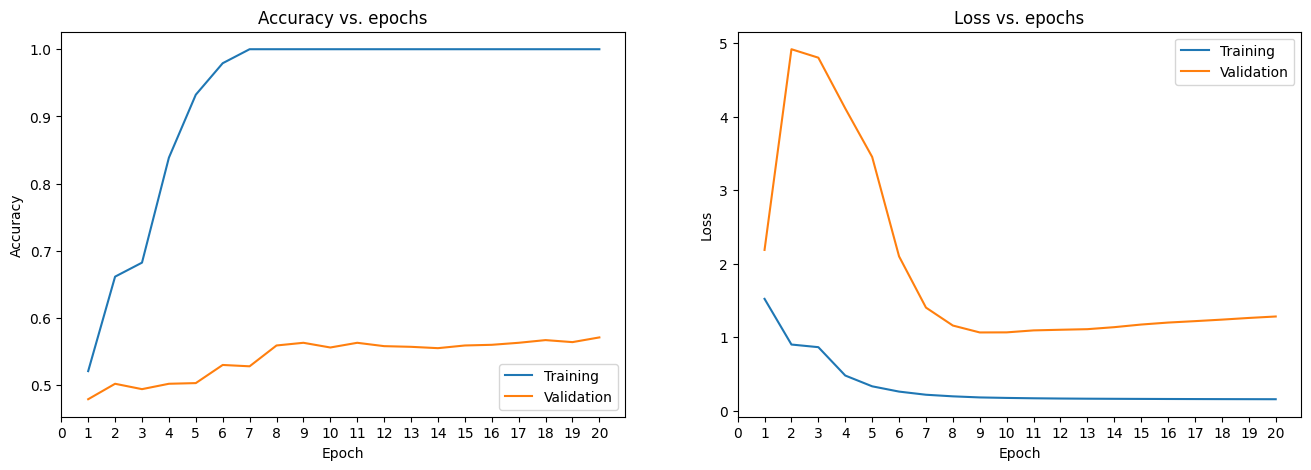

2022-08-17 07:52:37,224: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_100/resnet_v1_20


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_100/resnet_v1_20
----------------------------------------evaluate----------------------------------------
32/32 [==============================] - 1s 34ms/step


2022-08-17 07:52:47,502: INFO: test loss:1.2837
2022-08-17 07:52:47,503: INFO: test accuracy:0.5710
2022-08-17 07:52:47,507: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_100/results.json
2022-08-17 07:52:47,508: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_100/results.json
2022-08-17 07:52:47,509: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_100/default.generator
2022-08-17 07:52:47,510: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_100/default.generator
2022-08-17 07:52:47,511: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_100/vg

----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2022-08-17 07:52:49,379: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_100/default.generator


32/32 [==============================] - 2s 44ms/step


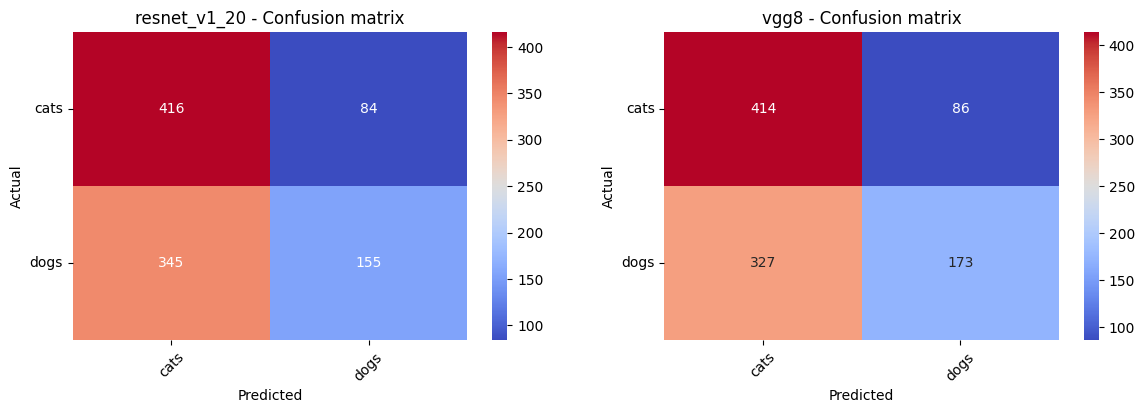

----------------------------------------models----------------------------------------


model_name                 program_name  weight_number  train_time  \
1          vgg8  catsdogs_0808_cnt_100.ipynb       14254786        60.4   
2  resnet_v1_20  catsdogs_0808_cnt_100.ipynb         275618       119.1   
3        lenet1  catsdogs_0808_cnt_100.ipynb        2785850         9.6   
4          mlp1  catsdogs_0808_cnt_100.ipynb        9830786         7.0   
5       custom1  catsdogs_0808_cnt_100.ipynb        1383938        15.9   

        create_time  train_loss  test_loss  train_accuracy  test_accuracy  \
1  2022-08-17 07:50      7.8956    15.3633           0.600          0.587   
2  2022-08-17 07:52      0.7203     1.2837           0.735          0.571   
3  2022-08-17 07:48      0.6312     0.7027           0.665          0.565   
4  2022-08-17 07:48      6.9909    18.5224           0.740          0.564   
5  2022-08-17 07:49      1.8811     2.0097           0.600          0.531   

   train_auc  test_auc  
1     0.6898    0.5917  
2     0.9126    0.6249  
3     0.6944    0.5830  
4     0.8192    0.5766  
5     0.6058    0.5379

In [30]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.resnet_v1(helper, name='resnet_v1', depth=20, preprocess_fun=rescale)
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=False) 

### Pretrained Model + Fune-Tune

In [31]:
input_shape = [160, 160, 3]

def resize(shape):
    def resize_(x):
        return tf.image.resize(x, shape)
    return resize_

In [32]:
preprocess_fun =  [rescale]

(32, 160, 160, 3) <class 'tensorflow.python.framework.ops.EagerTensor'>


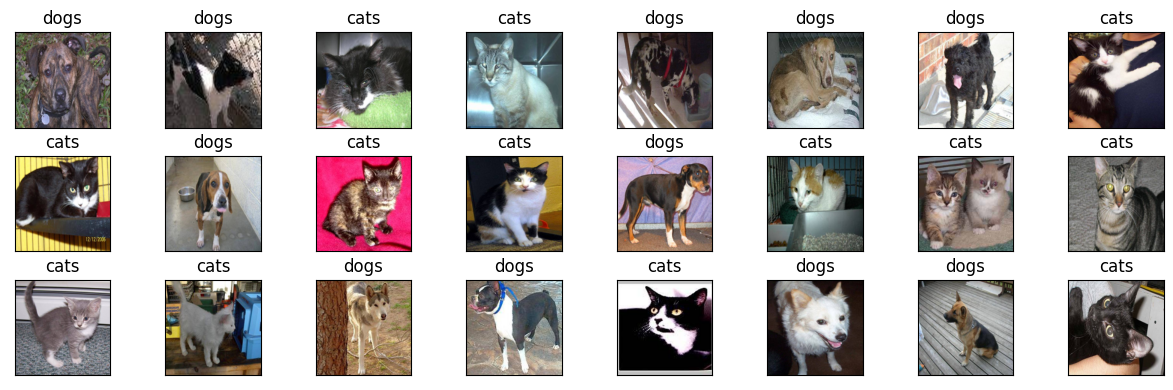

In [33]:
sample_images1 = resize(input_shape[:-1])(sample_images)
print(sample_images1.shape, type(sample_images1)) 
qtf.utils.show_images(sample_images1.numpy(), sample_labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4))

#### MobileNet V2

In [34]:
base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_6[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 20, 20, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_depthwise_relu (ReLU)  (None, 20, 20, 144)  0           ['block_3_depthwise_BN[0][0]']   
                                                                                                  
 block_3_project (Conv2D)       (None, 20, 20, 32)   4608        ['block_3_depthwise_relu[0][0]'] 
                                                                                                  
 block_3_project_BN (BatchNorma  (None, 20, 20, 32)  128         ['block_3_project[0][0]']        
 lization)

 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 10, 10, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 10, 10, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)                                                                                            
                                                                                                  
 block_7_depthwise_BN (BatchNor  (None, 10, 10, 384)  1536       ['block_7_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_7_d

 block_10_project_BN (BatchNorm  (None, 10, 10, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 10, 10, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_expand_BN (BatchNorma  (None, 10, 10, 576)  2304       ['block_11_expand[0][0]']        
 lization)                                                                                        
                                                                                                  
 block_11_expand_relu (ReLU)    (None, 10, 10, 576)  0           ['block_11_expand_BN[0][0]']     
                                                                                                  
 block_11_

                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 5, 5, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 5, 5, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_project_BN (BatchNorm  (None, 5, 5, 160)   640         ['block_14_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_14_add (Add)             (None, 5, 5, 160)    0           ['block_13_project_BN[0][0]',    
                                                                  'block_14_project_BN[0][0]']    
          

In [35]:
def pretrained_model(helper, base_model, dropout=None, name='pretrained_model', last_activation=None, preprocess_fun=None):
    if dropout is None:
        dropout = helper.params.get_model_param(name, 'dropout')

    input_shape = qbz95.tf.classification.get_input_shape(helper.datasets.train_dataset)
    input = layers.Input(shape=input_shape)
    x = qbz95.tf.classification.image_models.process_funs(input, preprocess_fun)
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    if dropout > 0: x = layers.Dropout(dropout)(x)
    x = helper.get_dense_layer(len(helper.params.classes), activation=last_activation)(x)

    model = Model(inputs=input, outputs=x, name=name)
    helper.compile(model)
    return model

def fine_tuning(helper, model, base_model, fine_tune_at, learning_rate=0.00001):
    base_model.trainable = True
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False    
    model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=helper.params.metrics)
    return model 

In [36]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = pretrained_model(helper, base_model, dropout=0.2, name='pretrained-MobileNetV2', preprocess_fun=preprocess_fun)
print(f'len(model.trainable_variables)={len(model.trainable_variables)}')
model.summary()

loss0, accuracy0 = model.evaluate(datasets.test_dataset)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

2022-08-17 07:52:57,567: INFO: model_params.pretrained-MobileNetV2.learning_rate=0.0001
2022-08-17 07:52:57,568: INFO: model_params.pretrained-MobileNetV2.clip_value=None
2022-08-17 07:52:57,577: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_100/pretrained-MobileNetV2


len(model.trainable_variables)=2
Model: "pretrained-MobileNetV2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 160, 160, 3)       0         
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout_10 (Dropout)        (None, 1280)              0         
                                                                 
 dense_10 (

2022-08-17 07:53:00,154: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_100/pretrained-MobileNetV2, monitor=val_accuracy)
2022-08-17 07:53:00,154: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2022-08-17 07:53:00,155: INFO: steps_per_epoch=6
2022-08-17 07:53:00,156: INFO: start training
2022-08-17 07:53:00,157: INFO: use_class_weight=False


Epoch 1/10
4/6 [===================>..........] - ETA: 0s - loss: 0.7977 - accuracy: 0.5078 

2022-08-17 07:53:18,932: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_100/pretrained-MobileNetV2/assets


2022-08-17 07:53:23,746: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_100/pretrained-MobileNetV2/assets


6/6 [==============================] - 24s 4s/step - loss: 0.7625 - accuracy: 0.5312 - val_loss: 0.6676 - val_accuracy: 0.5900
Epoch 2/10
4/6 [===================>..........] - ETA: 0s - loss: 0.7551 - accuracy: 0.5312

2022-08-17 07:53:40,934: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_100/pretrained-MobileNetV2/assets


2022-08-17 07:53:45,432: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_100/pretrained-MobileNetV2/assets


6/6 [==============================] - 22s 4s/step - loss: 0.7148 - accuracy: 0.5729 - val_loss: 0.6100 - val_accuracy: 0.6610
Epoch 3/10
4/6 [===================>..........] - ETA: 0s - loss: 0.6632 - accuracy: 0.6484

2022-08-17 07:54:02,802: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_100/pretrained-MobileNetV2/assets


2022-08-17 07:54:07,597: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_100/pretrained-MobileNetV2/assets


6/6 [==============================] - 22s 4s/step - loss: 0.6438 - accuracy: 0.6458 - val_loss: 0.5587 - val_accuracy: 0.7300
Epoch 4/10
4/6 [===================>..........] - ETA: 0s - loss: 0.5987 - accuracy: 0.6719

2022-08-17 07:54:24,755: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_100/pretrained-MobileNetV2/assets


2022-08-17 07:54:29,191: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_100/pretrained-MobileNetV2/assets


6/6 [==============================] - 22s 4s/step - loss: 0.5762 - accuracy: 0.7031 - val_loss: 0.5137 - val_accuracy: 0.7680
Epoch 5/10
4/6 [===================>..........] - ETA: 0s - loss: 0.5473 - accuracy: 0.7344

2022-08-17 07:54:47,026: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_100/pretrained-MobileNetV2/assets


2022-08-17 07:54:51,594: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_100/pretrained-MobileNetV2/assets


6/6 [==============================] - 22s 4s/step - loss: 0.5584 - accuracy: 0.7292 - val_loss: 0.4732 - val_accuracy: 0.8030
Epoch 6/10
4/6 [===================>..........] - ETA: 0s - loss: 0.4831 - accuracy: 0.7344

2022-08-17 07:55:08,979: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_100/pretrained-MobileNetV2/assets


2022-08-17 07:55:13,785: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_100/pretrained-MobileNetV2/assets


6/6 [==============================] - 22s 4s/step - loss: 0.4859 - accuracy: 0.7500 - val_loss: 0.4372 - val_accuracy: 0.8240
Epoch 7/10
4/6 [===================>..........] - ETA: 0s - loss: 0.4946 - accuracy: 0.7500

2022-08-17 07:55:30,977: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_100/pretrained-MobileNetV2/assets


2022-08-17 07:55:35,832: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_100/pretrained-MobileNetV2/assets


6/6 [==============================] - 22s 4s/step - loss: 0.4815 - accuracy: 0.7500 - val_loss: 0.4053 - val_accuracy: 0.8460
Epoch 8/10
4/6 [===================>..........] - ETA: 0s - loss: 0.4276 - accuracy: 0.7812

2022-08-17 07:55:53,103: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_100/pretrained-MobileNetV2/assets


2022-08-17 07:55:57,975: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_100/pretrained-MobileNetV2/assets


6/6 [==============================] - 22s 4s/step - loss: 0.4269 - accuracy: 0.7760 - val_loss: 0.3767 - val_accuracy: 0.8740
Epoch 9/10
4/6 [===================>..........] - ETA: 0s - loss: 0.3876 - accuracy: 0.8516

2022-08-17 07:56:15,306: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_100/pretrained-MobileNetV2/assets


2022-08-17 07:56:19,808: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_100/pretrained-MobileNetV2/assets


6/6 [==============================] - 22s 4s/step - loss: 0.3967 - accuracy: 0.8333 - val_loss: 0.3516 - val_accuracy: 0.8910
Epoch 10/10
4/6 [===================>..........] - ETA: 0s - loss: 0.3694 - accuracy: 0.8359

2022-08-17 07:56:37,464: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_100/pretrained-MobileNetV2/assets


2022-08-17 07:56:42,337: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_100/pretrained-MobileNetV2/assets


6/6 [==============================] - 22s 4s/step - loss: 0.3520 - accuracy: 0.8490 - val_loss: 0.3296 - val_accuracy: 0.9010


2022-08-17 07:56:43,135: INFO: finish training [elapsed time: 222.98 seconds]


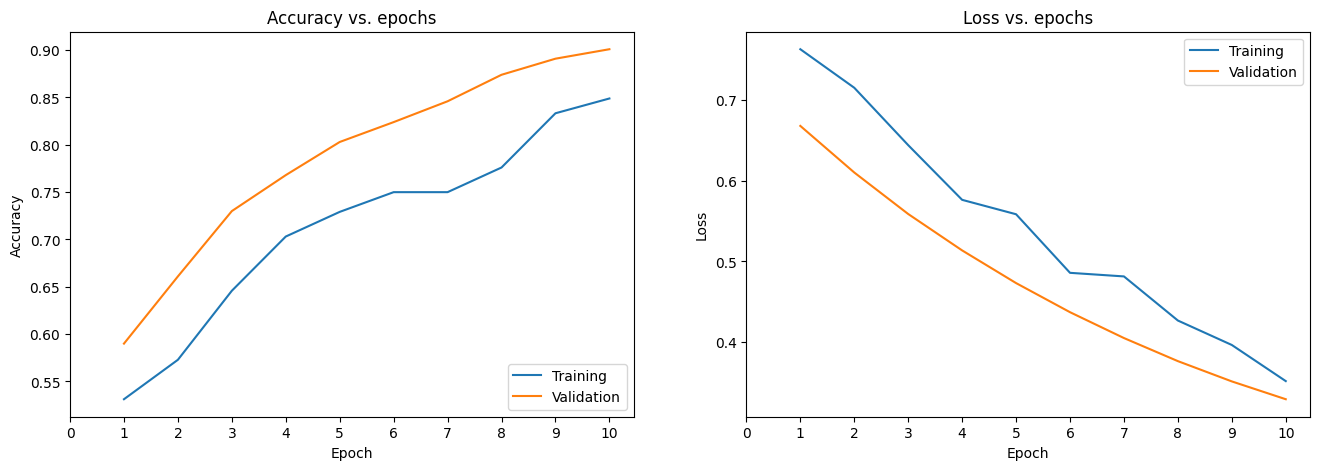

In [37]:
history = helper.train(model, epochs=10)

In [38]:
model = fine_tuning(helper, model, base_model, fine_tune_at=100, learning_rate=0.00001)
print(f'len(model.trainable_variables)={len(model.trainable_variables)}')

len(model.trainable_variables)=56


2022-08-17 07:56:43,628: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_100/pretrained-MobileNetV2, monitor=val_accuracy)
2022-08-17 07:56:43,629: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2022-08-17 07:56:43,630: INFO: steps_per_epoch=6
2022-08-17 07:56:43,630: INFO: start training
2022-08-17 07:56:43,631: INFO: use_class_weight=False


Epoch 1/10
5/6 [========================>.....] - ETA: 0s - loss: 0.2556 - accuracy: 0.9187

2022-08-17 07:57:06,249: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_100/pretrained-MobileNetV2/assets


2022-08-17 07:57:11,462: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_100/pretrained-MobileNetV2/assets


6/6 [==============================] - 29s 5s/step - loss: 0.2456 - accuracy: 0.9271 - val_loss: 0.1404 - val_accuracy: 0.9670
Epoch 2/10
5/6 [========================>.....] - ETA: 0s - loss: 0.1017 - accuracy: 0.9875

2022-08-17 07:57:28,972: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_100/pretrained-MobileNetV2/assets


2022-08-17 07:57:34,136: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_100/pretrained-MobileNetV2/assets


6/6 [==============================] - 23s 5s/step - loss: 0.1061 - accuracy: 0.9792 - val_loss: 0.1033 - val_accuracy: 0.9740
Epoch 3/10
5/6 [========================>.....] - ETA: 0s - loss: 0.0544 - accuracy: 1.0000

2022-08-17 07:57:51,857: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_100/pretrained-MobileNetV2/assets


2022-08-17 07:57:56,652: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_100/pretrained-MobileNetV2/assets


6/6 [==============================] - 23s 5s/step - loss: 0.0544 - accuracy: 1.0000 - val_loss: 0.0843 - val_accuracy: 0.9750
Epoch 4/10
5/6 [========================>.....] - ETA: 0s - loss: 0.0359 - accuracy: 1.0000

2022-08-17 07:58:14,415: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_100/pretrained-MobileNetV2/assets


2022-08-17 07:58:19,499: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_100/pretrained-MobileNetV2/assets


6/6 [==============================] - 23s 5s/step - loss: 0.0341 - accuracy: 1.0000 - val_loss: 0.0747 - val_accuracy: 0.9790
Epoch 5/10
6/6 [==============================] - 1s 181ms/step - loss: 0.0205 - accuracy: 1.0000 - val_loss: 0.0696 - val_accuracy: 0.9790
Epoch 6/10
6/6 [==============================] - 1s 181ms/step - loss: 0.0114 - accuracy: 1.0000 - val_loss: 0.0681 - val_accuracy: 0.9760
Epoch 7/10
6/6 [==============================] - 1s 182ms/step - loss: 0.0088 - accuracy: 1.0000 - val_loss: 0.0645 - val_accuracy: 0.9790
Epoch 8/10
6/6 [==============================] - 1s 181ms/step - loss: 0.0129 - accuracy: 0.9948 - val_loss: 0.0663 - val_accuracy: 0.9770
Epoch 9/10
6/6 [==============================] - 1s 182ms/step - loss: 0.0070 - accuracy: 1.0000 - val_loss: 0.0665 - val_accuracy: 0.9770
Epoch 10/10
6/6 [==============================] - 1s 183ms/step - loss: 0.0031 - accuracy: 1.0000 - val_loss: 0.0677 - val_accuracy: 0.9760


2022-08-17 07:58:26,017: INFO: finish training [elapsed time: 102.39 seconds]


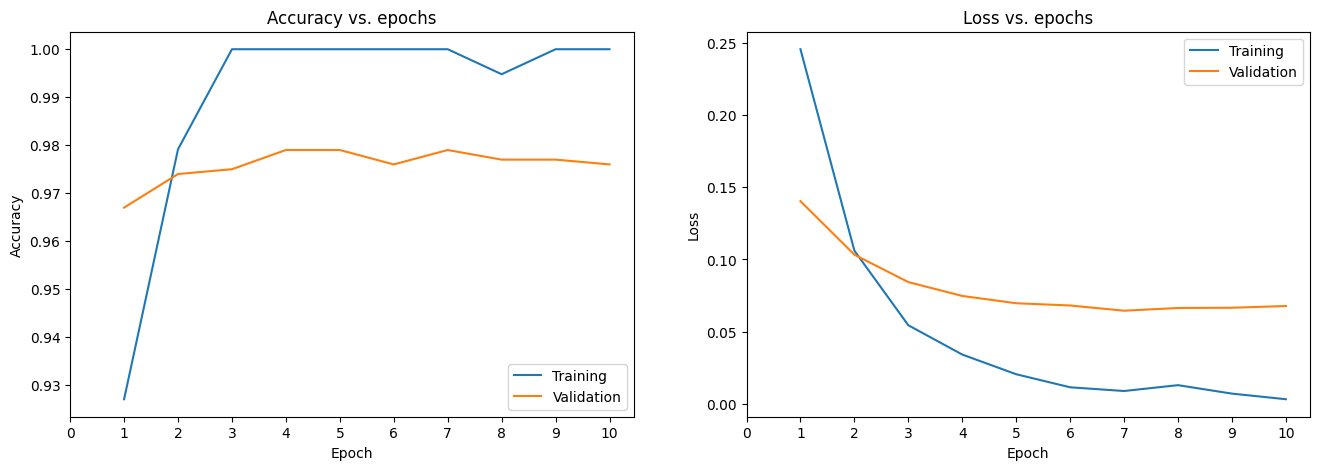

2022-08-17 07:58:26,362: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_100/pretrained-MobileNetV2


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_100/pretrained-MobileNetV2
----------------------------------------evaluate----------------------------------------
32/32 [==============================] - 1s 23ms/step


2022-08-17 07:58:42,271: INFO: test loss:0.0747
2022-08-17 07:58:42,271: INFO: test accuracy:0.9790
2022-08-17 07:58:42,275: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_100/results.json
2022-08-17 07:58:42,276: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_100/results.json
2022-08-17 07:58:42,277: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_100/default.generator
2022-08-17 07:58:42,278: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_100/default.generator
2022-08-17 07:58:42,279: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_100/vg

----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2022-08-17 07:58:43,934: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_100/default.generator


32/32 [==============================] - 2s 44ms/step


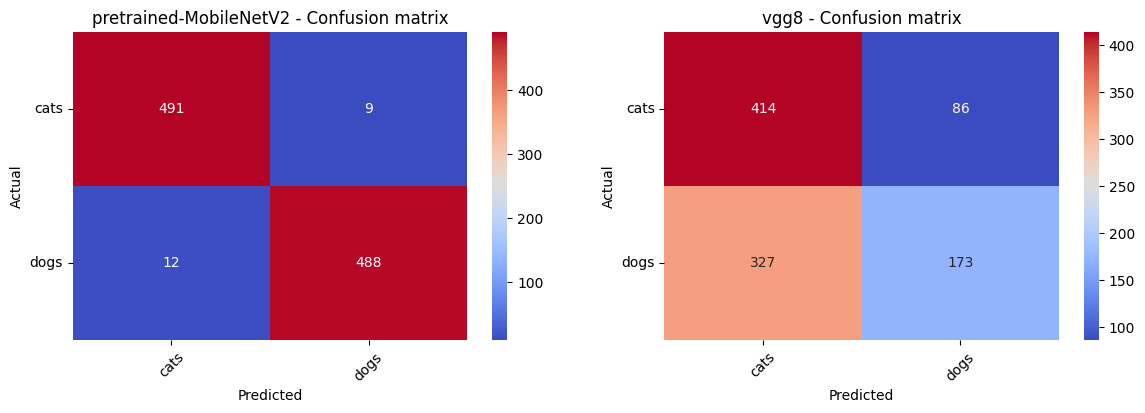

----------------------------------------models----------------------------------------


model_name                 program_name  weight_number  \
1  pretrained-MobileNetV2  catsdogs_0808_cnt_100.ipynb        1864002   
2                    vgg8  catsdogs_0808_cnt_100.ipynb       14254786   
3            resnet_v1_20  catsdogs_0808_cnt_100.ipynb         275618   
4                  lenet1  catsdogs_0808_cnt_100.ipynb        2785850   
5                    mlp1  catsdogs_0808_cnt_100.ipynb        9830786   
6                 custom1  catsdogs_0808_cnt_100.ipynb        1383938   

   train_time       create_time  train_loss  test_loss  train_accuracy  \
1       102.4  2022-08-17 07:58      0.0180     0.0747           1.000   
2        60.4  2022-08-17 07:50      7.8956    15.3633           0.600   
3       119.1  2022-08-17 07:52      0.7203     1.2837           0.735   
4         9.6  2022-08-17 07:48      0.6312     0.7027           0.665   
5         7.0  2022-08-17 07:48      6.9909    18.5224           0.740   
6        15.9  2022-08-17 07:49      1.8811     2.0097           0.600   

   test_accuracy  train_auc  test_auc  
1          0.979     1.0000    0.9970  
2          0.587     0.6898    0.5917  
3          0.571     0.9126    0.6249  
4          0.565     0.6944    0.5830  
5          0.564     0.8192    0.5766  
6          0.531     0.6058    0.5379

In [39]:
history = helper.train(model, epochs=10)
helper.model_summary(model, history, show_sample_analysis=False) 

## Evaluation

### Best Model

In [40]:
data_model_results = qtf.classification.DataModelResults(params.data_path) 
data_model_results.show(10)

2022-08-17 07:58:48,251: INFO: getting results for /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs
2022-08-17 07:58:48,253: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/results.json
2022-08-17 07:58:48,254: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/results.json
2022-08-17 07:58:48,256: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_100/results.json


model_name                  program_name  weight_number  \
1   pretrained-MobileNetV2   catsdogs_0808_cnt_500.ipynb        1864002   
2   pretrained-MobileNetV2  catsdogs_0808_cnt_1000.ipynb        1864002   
3   pretrained-MobileNetV2   catsdogs_0808_cnt_100.ipynb        1864002   
4             resnet_v1_20  catsdogs_0808_cnt_1000.ipynb         275618   
5             resnet_v1_20   catsdogs_0808_cnt_500.ipynb         275618   
6                  custom1  catsdogs_0808_cnt_1000.ipynb        1383938   
7                  custom1   catsdogs_0808_cnt_500.ipynb        1383938   
8                   lenet1   catsdogs_0808_cnt_500.ipynb        2785850   
9                     mlp1  catsdogs_0808_cnt_1000.ipynb        9830786   
10                    mlp1   catsdogs_0808_cnt_500.ipynb        9830786   

    train_time       create_time  train_loss  test_loss  train_accuracy  \
1         45.5  2022-08-17 06:36      0.0328     0.0521          0.9920   
2         68.1  2022-08-17 06:20      0.0235     0.0428          0.9935   
3        102.4  2022-08-17 07:58      0.0180     0.0747          1.0000   
4        314.5  2022-08-17 06:14      0.1710     0.8164          0.9980   
5        242.6  2022-08-17 06:31      0.1704     0.9884          0.9990   
6         98.1  2022-08-17 06:03      0.4033     0.6511          0.8155   
7         55.4  2022-08-17 06:24      0.4172     0.7458          0.8130   
8         37.1  2022-08-17 06:23      0.6200     1.2310          0.7370   
9         20.6  2022-08-17 06:00      0.2677     3.3658          0.9190   
10        13.6  2022-08-17 06:22      1.0128     7.2357          0.8110   

    test_accuracy  train_auc  test_auc  
1           0.986     0.9999    0.9990  
2           0.985     0.9996    0.9988  
3           0.979     1.0000    0.9970  
4           0.758     1.0000    0.8269  
5           0.714     1.0000    0.7936  
6           0.687     0.9068    0.7664  
7           0.664     0.8973    0.7197  
8           0.647     0.8425    0.6968  
9           0.597     0.9722    0.6200  
10          0.591     0.8976    0.6064

In [41]:

predictors = qtf.classification.Predictor.get_top_n_predictors(5, data_model_results)

best_predictor = predictors[0]
best_predictor.model.compile(optimizer=optimizers.Adam(learning_rate=params.learning_rate),
                        loss=losses.SparseCategoricalCrossentropy(from_logits=True),
                        metrics=['accuracy', 'mae'])

qtf.utils.plot_model_structure(best_predictor.model)

2022-08-17 07:58:48,335: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/pretrained-MobileNetV2
2022-08-17 07:58:58,048: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/default.generator
2022-08-17 07:58:58,073: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/pretrained-MobileNetV2
2022-08-17 07:59:07,939: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/default.generator
2022-08-17 07:59:07,962: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_100/pretrained-MobileNetV2
2022-08-17 07:59:17,866: INFO: loading genera

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


None

1/1 [==============================] - 1s 855ms/step


2022-08-17 07:59:31,217: WARNING: 5 out of the last 36 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7fbb842b91f0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/1 [==============================] - 0s 448ms/step


2022-08-17 07:59:31,687: WARNING: 6 out of the last 37 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7fba8d758280> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/1 [==============================] - 0s 14ms/step


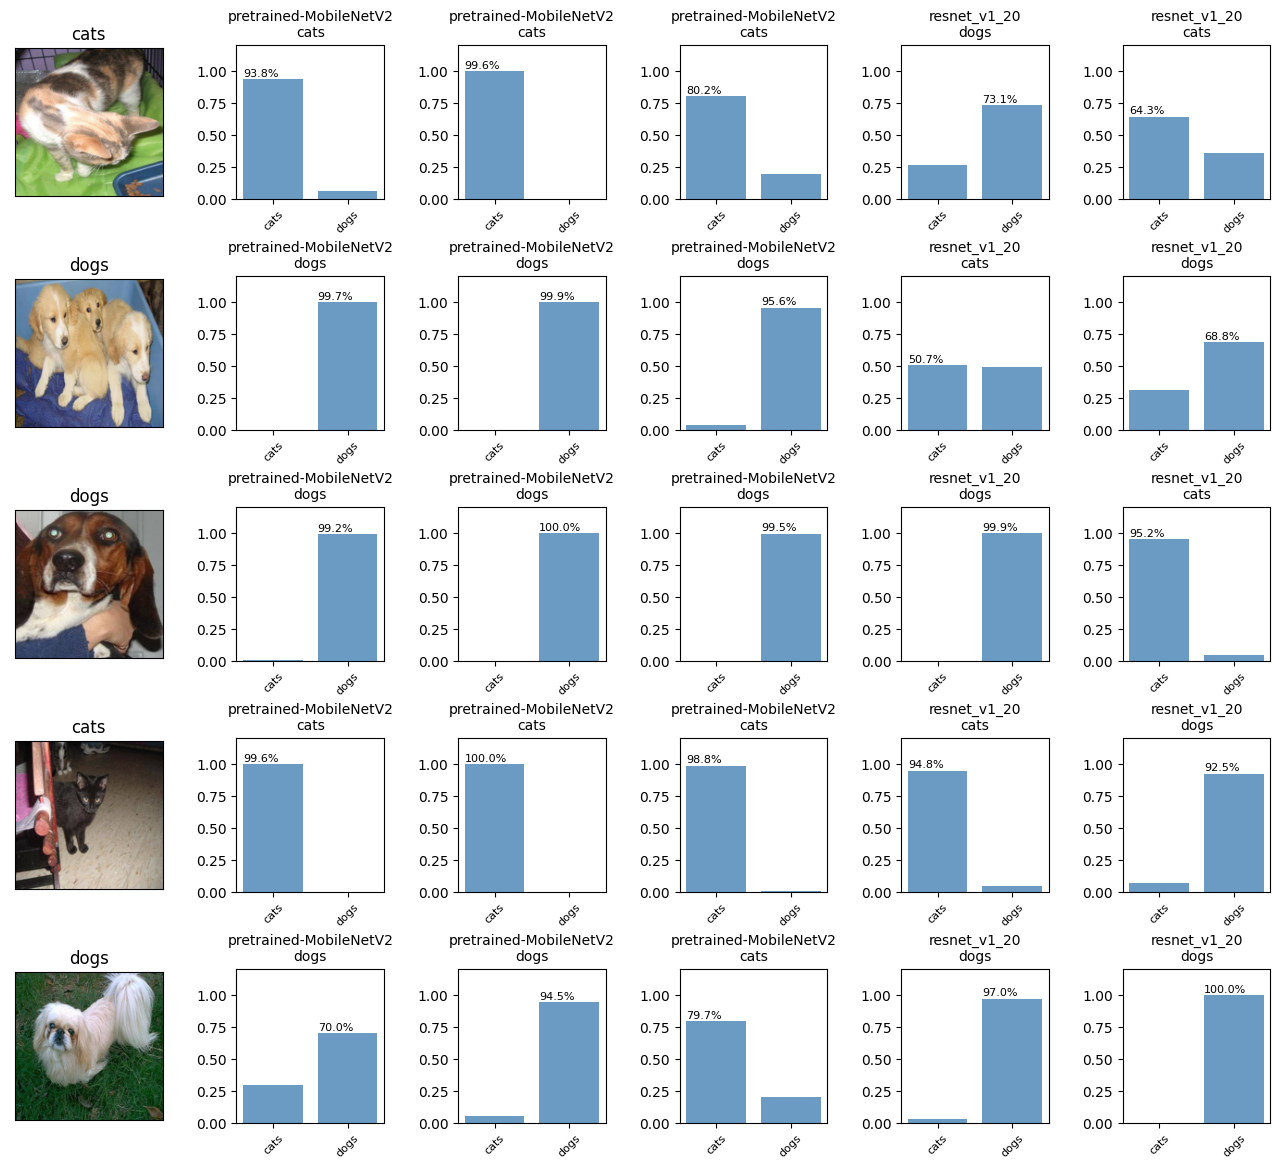

In [42]:
qtf.utils.plot_sample_image_analysis(predictors, test_images, test_labels,
                                    sample_count=5, show_error_sample=False) 

1/1 [==============================] - 0s 12ms/step


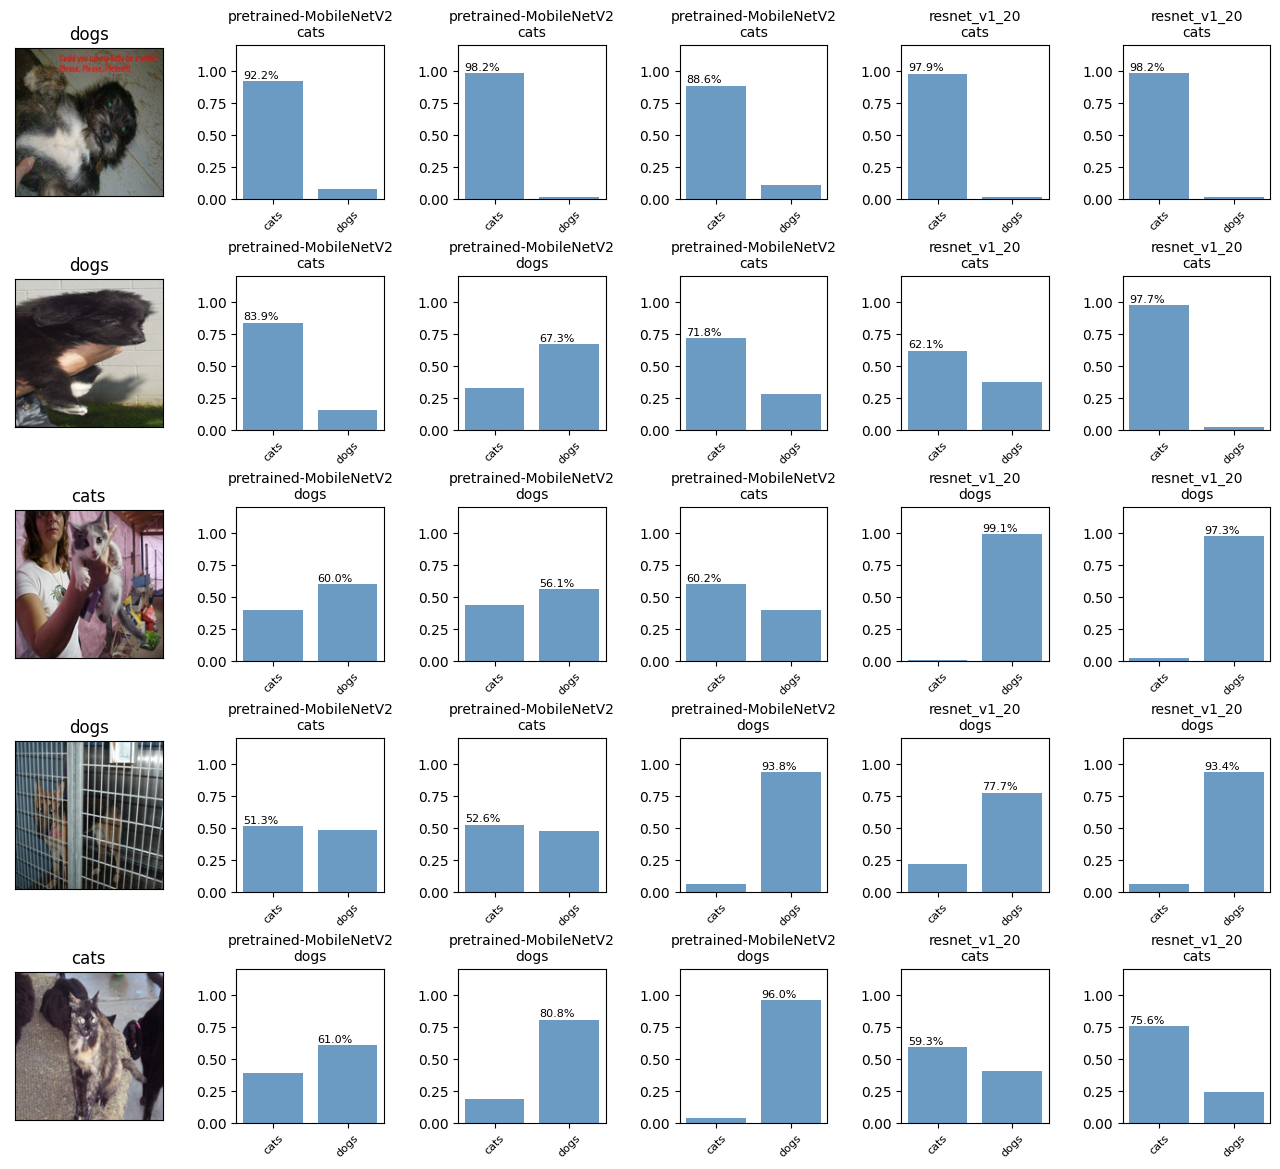

In [43]:
qtf.utils.plot_sample_image_analysis(predictors, test_images, test_labels,
                                    sample_count=5, show_error_sample=True) 

### Evaluate

In [44]:
results = best_predictor.evaluate(test_images, test_labels)
print(results)

predictions = best_predictor.predict(test_images)
print(predictions.shape)

{'loss': 0.052060939371585846, 'accuracy': 0.9860000014305115, 'mae': 2.655226230621338}
32/32 [==============================] - 1s 23ms/step
(1000, 2)


In [45]:
top1_predictions = best_predictor.predict_top_k(test_images, test_labels, top_k=1)
top1_scores = qtf.utils.score(test_labels, top1_predictions, params.classes)
display(top1_scores)
print('-'*100)
print(classification_report(test_labels, top1_predictions, digits=4, target_names=params.classes))

32/32 [==============================] - 1s 23ms/step


precision  recall        f1
cats   0.984064   0.988  0.986028
dogs   0.987952   0.984  0.985972

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

        cats     0.9841    0.9880    0.9860       500
        dogs     0.9880    0.9840    0.9860       500

    accuracy                         0.9860      1000
   macro avg     0.9860    0.9860    0.9860      1000
weighted avg     0.9860    0.9860    0.9860      1000



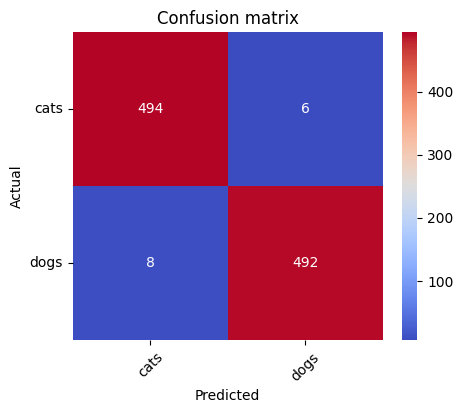

In [46]:
qtf.utils.plot_confusion_matrix(test_labels, top1_predictions, params.classes)


## Reference

- [Text classification Guide](https://developers.google.com/machine-learning/guides/text-classification)